<a href="https://colab.research.google.com/github/jeenathampi/DMClustering/blob/master/ClusteringDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Various Clustering techniques

##Load all the required libraries

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy.spatial.distance import  pdist
from scipy.cluster.hierarchy import cut_tree
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from collections import Counter

##Dataset - Heart Disease

Features:

1. Age | int (days)
2. Height | int (cm) |
3. Weight | float (kg) |
4. Gender | categorical code |
5. Systolic blood pressure | ap_hi | int |
6. Diastolic blood pressure | ap_lo | int |
7. Cholesterol | 1: normal, 2: above normal, 3: well above normal |
8. Glucose | 1: normal, 2: above normal, 3: well above normal |
9. Smoking | binary |
10. Alcohol intake | alco | binary |
11. Physical activity | active | binary |
12. Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [54]:
df = pd.read_csv("https://kmeanscluster.s3.amazonaws.com/newHeartDataset.csv")
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


###Data cleaning and preparation

In [55]:
df.drop(df.query('ap_hi >220 or ap_lo >180 or ap_hi<40 or ap_lo<40').index, axis=0, inplace=True)
df.drop('id', axis='columns',inplace=True)
N = 65000
df = df.iloc[N: , :]

In [56]:
df['age'] = round(df['age']/365.25,2)
df.insert(5, 'bmi', round((df['weight']/(df['height']/100)**2), 2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
df['syst_high'] = df['ap_hi'] > 140
df['syst_high'] = df['syst_high'].astype(int)
df['healthy'] = df['bmi']<24.9
df['healthy'] = df['healthy'].astype(int)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,age,gender,height,weight,ap_hi,bmi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,syst_high,healthy
66165,39.73,2,178,70.0,100,22.09,70,1,1,0,0,0,0,0,1
66166,59.80,1,155,76.0,140,31.63,80,3,1,0,0,0,1,0,0
66167,41.68,1,158,62.0,100,24.84,60,1,1,0,0,1,0,0,1
66168,48.13,2,168,63.0,140,22.32,80,1,1,0,0,1,1,0,1
66169,48.34,1,170,80.0,150,27.68,100,1,1,0,0,0,1,1,0


In [58]:
df.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
bmi            0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
syst_high      0
healthy        0
dtype: int64

Below figure shows the gender distribution in the dataset

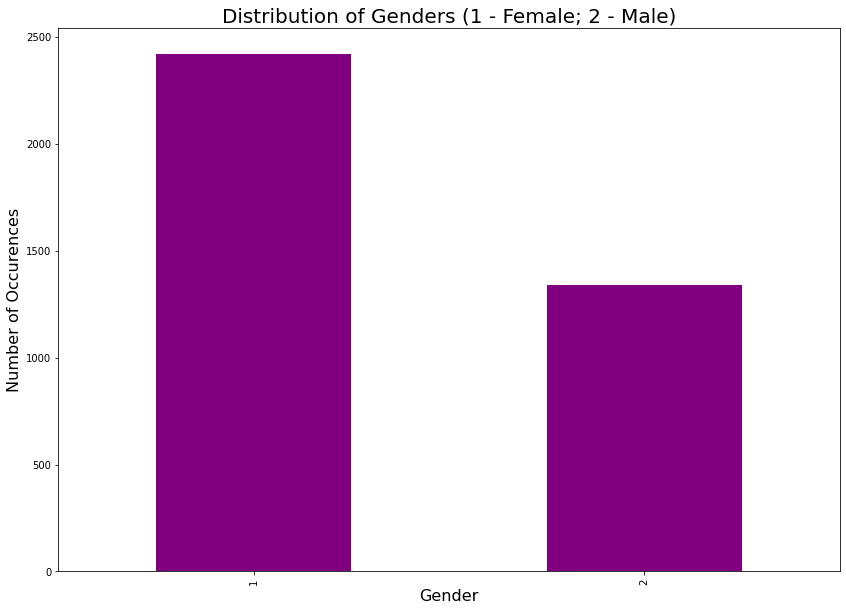

In [59]:
# Gender Distribution
fig, axes = plt.subplots(figsize = (14, 10))
axes.set_title('Distribution of Genders (1 - Female; 2 - Male)', fontsize = 20)
axes.set_xlabel("Gender", fontsize = 16)
axes.set_ylabel("Number of Occurences", fontsize = 16)
df["gender"].value_counts().plot(ax = axes, kind = "bar", color = "purple")

###Feature selection

Taking features age and ap_hi(systolic blood pressure) to do clustering

In [60]:
data = df.drop(['gender', 'height','weight','bmi','ap_lo','cholesterol','gluc','smoke','alco','active','cardio','syst_high','healthy'], axis=1)
data

,age,ap_hi
66165,39.73,100
66166,59.80,140
66167,41.68,100
66168,48.13,140
66169,48.34,150
...,...,...
69995,52.68,120
69996,61.88,140
69997,52.20,180
69998,61.41,135


###Scaling the data

In [61]:
scaler = MinMaxScaler()
df1 = pd.DataFrame(scaler.fit_transform(data),columns=['age','ap_hi'])
df1

,age,ap_hi
0,0.021773,0.142857
1,0.802100,0.428571
2,0.097589,0.142857
3,0.348367,0.428571
4,0.356532,0.500000
...,...,...
3759,0.525272,0.285714
3760,0.882970,0.428571
3761,0.506610,0.714286
3762,0.864697,0.392857


##K-Means Clustering

###Building the Model
To decide optimum cluster number , will use elbow method

In [62]:

k_rng = range(1,10)
sse = []
for k in k_rng:
  km = KMeans(n_clusters=k)
  km.fit(df1[['age','ap_hi']])
  sse.append(km.inertia_)

In [63]:
sse

[311.2347501029162,
 128.3969470292239,
 84.6304464459956,
 67.51967772182843,
 54.070570152189944,
 45.202053971265,
 38.87158261272167,
 34.573469637840645,
 31.063815690085978]

###Visualizing the elbow method to get the optimal value of K

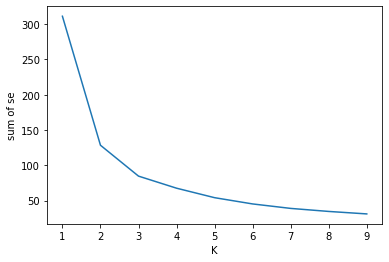

In [64]:
plt.xlabel('K')
plt.ylabel('sum of se')
plt.plot(k_rng,sse)

In [65]:
km = KMeans(n_clusters=3)
km

KMeans(n_clusters=3)

In [66]:
y_predicted = km.fit_predict(df1[['age','ap_hi']])
y_predicted

array([0, 1, 0, ..., 2, 1, 2], dtype=int32)

In [67]:
km.cluster_centers_

array([[0.19491709, 0.30016352],
       [0.83489832, 0.36073113],
       [0.53889345, 0.33566297]])

###Visualizing all the clusters

No handles with labels found to put in legend.


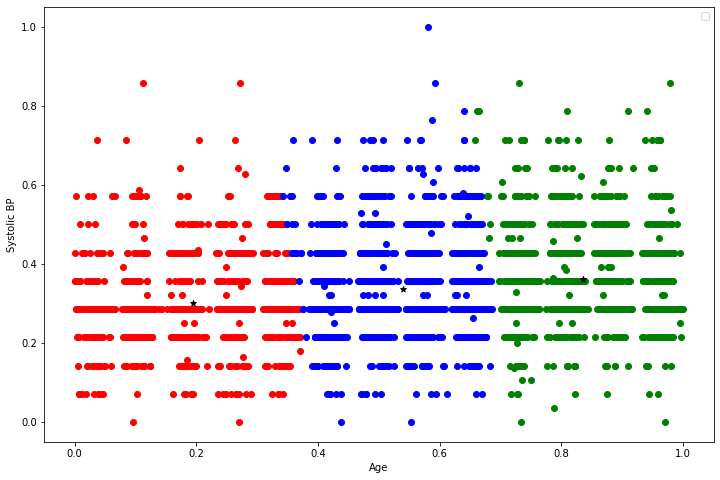

In [68]:
df1['cluster_kmeans'] = y_predicted
df2 = df1[df1.cluster_kmeans==0]
df3 = df1[df1.cluster_kmeans==1]
df4 = df1[df1.cluster_kmeans==2]
plt.figure(figsize=(12, 8))

plt.scatter(df2.age,df2.ap_hi,color='red')
plt.scatter(df3.age,df3.ap_hi,color='green')
plt.scatter(df4.age,df4.ap_hi,color='blue')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='black',marker='*')

plt.xlabel('Age')
plt.ylabel('Systolic BP')
plt.legend()

##Hierarchical Clustering

###Single Linkage

Using SIngle Linkage where the distance between two clusters is defined as the shortest distance between two points in each cluster.

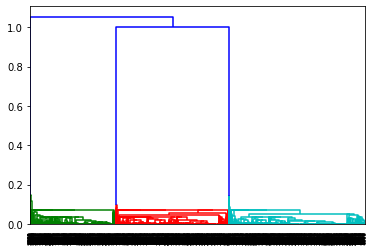

In [69]:
mergings = linkage(df1, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

###Complete Linkage

Complete Linkage where the distance between two clusters is defined as the longest distance between two points in each cluster

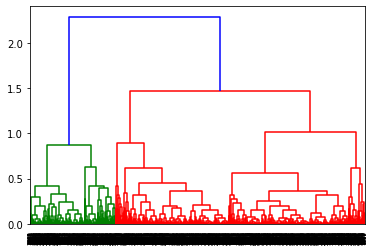

In [70]:
mergings = linkage(df1, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

### Average Linkage

Average Linkage where the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster.

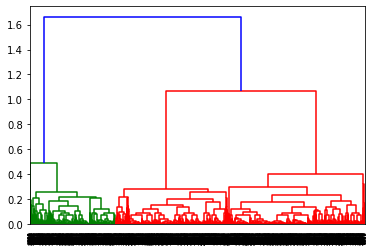

In [71]:
mergings = linkage(df1, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

In [72]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 2, 1, 2])

### Assign cluster labels

In [73]:

df1['Cluster_Labels'] = cluster_labels
df1.head()

,age,ap_hi,cluster_kmeans,Cluster_Labels
0,0.021773,0.142857,0,0
1,0.802100,0.428571,1,1
2,0.097589,0.142857,0,0
3,0.348367,0.428571,0,0
4,0.356532,0.500000,2,2


### Plot Cluster Id vs ap_hi

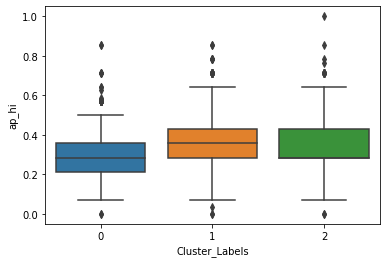

In [74]:
# Plot Cluster Id vs ap_hi

sns.boxplot(x='Cluster_Labels', y='ap_hi', data=df1)

##GMM - Gaussian mixture models clustering

In [75]:

gmm = GaussianMixture(n_components=3)
gmm

GaussianMixture(n_components=3)

In [76]:
y_predicted = gmm.fit_predict(df[['age','ap_hi']])
y_predicted

array([1, 0, 1, ..., 2, 0, 1])

###Cluster plot between age and systolic blood presssure

No handles with labels found to put in legend.


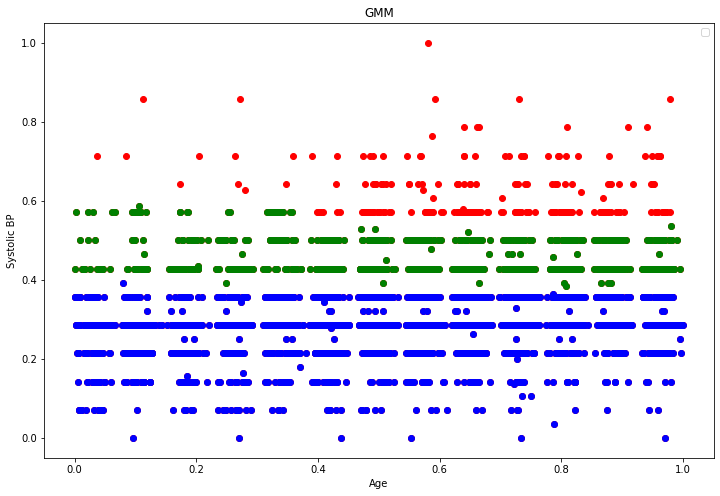

In [77]:
df1['cluster_gmm'] = y_predicted
df2 = df1[df1.cluster_gmm==0]
df3 = df1[df1.cluster_gmm==1]
df4 = df1[df1.cluster_gmm==2]

plt.figure(figsize=(12, 8))
plt.scatter(df1.age,df1.ap_hi,color='red')
plt.scatter(df2.age,df2.ap_hi,color='green')
plt.scatter(df3.age,df3.ap_hi,color='blue')

plt.xlabel('Age')
plt.ylabel('Systolic BP')
plt.title('GMM')
plt.legend()

##DB Scan clustering

In [78]:

model=DBSCAN(eps=0.1,min_samples=10).fit(df1)
print(model.labels_)

[0 1 0 ... 7 1 4]


#### Assign cluster labels

In [79]:
df1['cluster_dbscan'] = model.labels_
df1.head()

,age,ap_hi,cluster_kmeans,Cluster_Labels,cluster_gmm,cluster_dbscan
0,0.021773,0.142857,0,0,1,0
1,0.802100,0.428571,1,1,0,1
2,0.097589,0.142857,0,0,1,0
3,0.348367,0.428571,0,0,0,2
4,0.356532,0.500000,2,2,0,3


In [80]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy']
vectorizer = np.vectorize(lambda : colors[x % len(colors)])

###Plot between age and systolic blood pressure

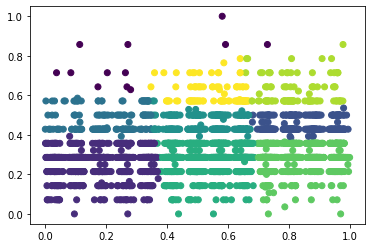

In [81]:
plt.scatter(df1['age'], df1['ap_hi'], c=df1['cluster_dbscan']);

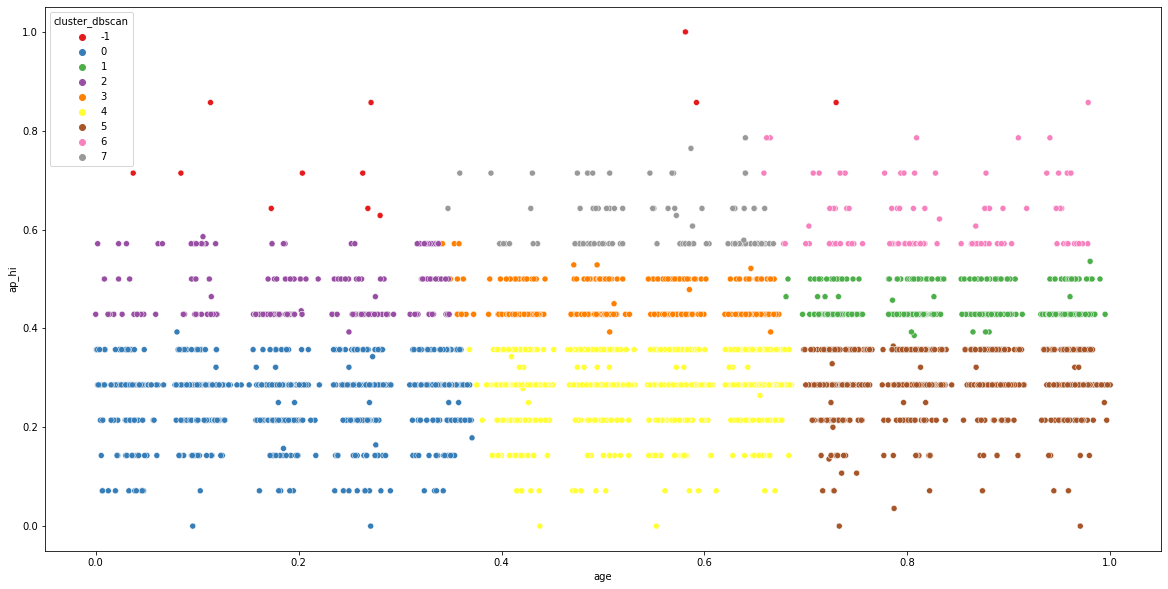

In [82]:
plt.figure(figsize=(20,10))

sns.scatterplot(x = 'age', y = 'ap_hi', hue = 'cluster_dbscan', data = df1, palette = 'Set1');

###Profiling the clusters

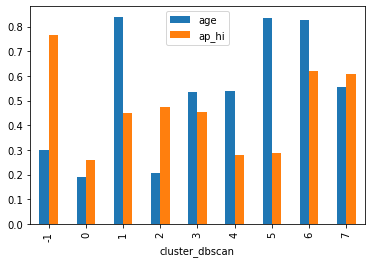

In [83]:
#Profiling the clusters
df1.drop(['cluster_kmeans','Cluster_Labels','cluster_gmm'],axis=1).groupby('cluster_dbscan').mean().plot(kind='bar')
plt.show()